# HelloWorld: IceCube - Neutrinos in Deep Ice

## Splitting large metadata file in chunks

The input detector response files are split into batches, but metadata is stored in a single file of almost 4GB. We want to avoid holding that in memory all the time, so the code below splits this metadata into batches.

In Jupyter you can write files using the `%%file` magic, and then run them with python using a command `!python FILENAME ARGS` within a cell.

In [1]:
%%file partition_meta.py
"""
Script that partitions large metadata file into smaller files
- separate file per each batch.

Usage:
    python partition_meta.py SPLIT
where SPLIT is either `train` or `test`
"""

from pathlib import Path
import sys, gc

import polars as pl
import pyarrow.parquet as pq
from tqdm import trange

# base path with input data
bp = Path("/kaggle/input/icecube-neutrinos-in-deep-ice")

def iter_through_meta(folder, chunk_size=100):
    """
    Read the large metadata file in chunks of batches.
    
    Parameters
    ----------
    folder : str
        Which part of the data to process. Should be either "train" or "test".

    Returns
    -------
    generator
        A generator of chunks of batches in pyarrow.Table format.
    """
    assert folder in ["train", "test"], "Argument `folder` should either be 'train' or 'test'"
    src_file = bp / f"{folder}_meta.parquet"
    all_batch_ids = pl.read_parquet(src_file, columns=["batch_id"]).unique().sort("batch_id")
    for chunk_first in trange(0, len(all_batch_ids), chunk_size):
        selection = all_batch_ids[chunk_first: chunk_first + chunk_size]["batch_id"]
        first, last = selection.min(), selection.max()
        yield pq.read_table(src_file, filters=[
            ("batch_id", ">=", first),
            ("batch_id", "<=", last),
        ])
        gc.collect()

def write_meta_batches(meta, folder):
    """
    Take a chunk of metadata info and write it to disk with separate file per batch.

    Parameters
    ----------
    meta : pyarrow.Table
        A table with a chunk of batches with metadata.
    folder : str
        Which to write into. Should be either "train" or "test".
    """
    folder.mkdir(exist_ok=True)
    pq.write_to_dataset(meta, root_path=folder, partition_cols=['batch_id'], flavor='spark')

def main(folder):
    """
    Read metatdata in chunks and save separate files per batch.
    
    Parameters
    ----------
    folder : str
        Which part of the data to process. Should be either "train" or "test".
    """
    print(f"Working on {folder}")
    for table in iter_through_meta(folder):
        write_meta_batches(table, Path(folder))
    print(f"Done ({folder})")
    
if __name__ == "__main__":
    try:
        _, folder = sys.argv
    except ValueError:
        print('Usage: "python partition_meta.py SPLIT", where SPLIT = "train" or "test"')
        exit(0)
    main(folder)

Writing partition_meta.py


Run the partitioning code (only if needed, which we check by the existence of the resulting folders):

In [2]:
from pathlib import Path

if not Path("train").exists():
    !python partition_meta.py train
if not Path("test").exists():
    !python partition_meta.py test

Working on train
100%|█████████████████████████████████████████████| 7/7 [02:39<00:00, 22.73s/it]
Done (train)
Working on test
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]
Done (test)


Kaggle has weird indicators for used memory: they seem to partially be including the cache. A more detailed info may be obtained lie this:

In [3]:
# Check how many resources we actually take
!top -bn1 -o '%MEM'

import os
print(f"(our pid: {os.getpid()})")

top - 04:03:31 up 6 min,  0 users,  load average: 2.02, 1.17, 0.51
Tasks:   4 total,   1 running,   3 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.0 us,  0.0 sy,  0.0 ni,  0.0 id,100.0 wa,  0.0 hi,  0.0 si,  0.0 st
MiB Mem :  16006.7 total,   6365.5 free,    589.4 used,   9051.8 buff/cache
MiB Swap:      0.0 total,      0.0 free,      0.0 used.  15086.7 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND
     25 root      20   0 1170660 209244  51672 S   0.0   1.3   0:10.12 python
     10 root      20   0  674208 126828  36096 S   0.0   0.8   0:03.58 python
   1507 root      20   0    7816   3520   3068 R   0.0   0.0   0:00.84 top
      1 root      20   0    5656   2748   2460 S   0.0   0.0   0:00.29 bash
(our pid: 25)


Finally, let's check that the number of metadata files we created is the same as the number of pulse files:

In [4]:
# base path
bp = Path("/kaggle/input/icecube-neutrinos-in-deep-ice")

def check_num_batches(split):
    num_actual = len(list(Path(split).glob("batch_id=*")))
    num_expected = len(list((bp / split).glob("batch_*.parquet")))

    if num_actual != num_expected:
        print(
            f"WARNING!!! Found {num_actual} batch files when expected {num_expected} for "
            f'split "{split}". Check that partitioning code ran ok.'
        )
    else:
        print(f"Check ok ({split})")

for split in ["train", "test"]:
    check_num_batches(split)

Check ok (train)
Check ok (test)


## Imports

(making all the necessary imports in a single cell)

In [5]:
from pathlib import Path
import gc
import os
from functools import lru_cache

import polars as pl
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True) # https://stackoverflow.com/questions/67419817/uncaught-error-script-error-for-plotly-http-requirejs-org-docs-errors-html
import plotly.graph_objects as go
import plotly.express as px
import torch
import pytorch_lightning as ptl
from tensorboard.backend.event_processing import event_accumulator

## Having a look at our data

There's a special file describing the geometry of the detector. Here we read it and convert its `sensor_id` column to the same dtype as we'll see in the pulse files.

In [6]:
sensors_df = pl.read_csv(bp / "sensor_geometry.csv").with_columns(pl.col("sensor_id").cast(pl.Int16))

print("sesnsors shape", sensors_df.shape)

sesnsors shape (5160, 4)


Here's a function to read a single batch of pulses:

In [7]:
def load_batch(folder, b_id):
    """
    Load a single batch of pulses.
    
    Parameters
    ----------
    folder : str
        Which part of the data to process. Should be either "train" or "test".
    b_id : int
        Index of the batch (as in the `batch_id` column).

    Returns
    -------
    polars.DataFrame
        Data frame with the loaded pulses.
    polars.DataFrame
        Data frame with corresponding metadata.
    """
    pulses = pl.read_parquet(bp / folder / f"batch_{b_id}.parquet")
    pulses = pulses.join(sensors_df, on="sensor_id").drop("sensor_id")

    meta = pl.read_parquet(f"{folder}/batch_id={b_id}/*.parquet")

    return pulses, meta

# Let's create an in-memory cache version of this function to avoid repeatedly
# loading the same batch when we examine various events from it. We'll delete this function
# later to free the memory taken by cache.
load_batch_c = lru_cache(maxsize=1)(load_batch)

Let's collect all the train and test `batch_id`s for easier positional indexing later on:

In [8]:
def get_batch_ids_from_folder(folder):
    fnames = [x.stem for x in (bp / folder).glob("*.parquet")]
    assert all(x.startswith("batch_") for x in fnames)
    return np.sort(np.array([int(x[6:]) for x in fnames]))

TRAIN_BIDS = get_batch_ids_from_folder("train")
TEST_BIDS = get_batch_ids_from_folder("test")

Now we want to see what our data tables look like. We're doing it inside of a function to avoid creating globals taking up memory later on.

In [9]:
def preview_data():
    b_pulses_train, b_meta_train = load_batch_c("train", TRAIN_BIDS[0])
    b_pulses_test, b_meta_test = load_batch("test", TEST_BIDS[0])

    display(HTML("<H1>Train meta:"))
    display(b_meta_train.head())

    display(HTML("<hr><H1>Test meta:"))
    display(b_meta_test.head())

    display(HTML("<hr><H1>Sensors:"))
    display(sensors_df.head())

    display(HTML("<hr><H1>Pulses batch train:"))
    display(b_pulses_train.head())

    display(HTML("<hr><H1>Pulses batch test:"))
    display(b_pulses_test.head())

    display(HTML("<hr><H1>Sample submission:"))
    display(pl.read_parquet(bp / "sample_submission.parquet").head())

preview_data()

event_id,first_pulse_index,last_pulse_index,azimuth,zenith
i64,i64,i64,f64,f64
24,0,60,5.029555,2.087498
41,61,111,0.417742,1.549686
59,112,147,1.160466,2.401942
67,148,289,5.845952,0.759054
72,290,351,0.653719,0.939117


event_id,first_pulse_index,last_pulse_index
i64,i64,i64
2092,0,298
7344,299,334
9482,335,377


sensor_id,x,y,z
i16,f64,f64,f64
0,-256.14,-521.08,496.03
1,-256.14,-521.08,479.01
2,-256.14,-521.08,461.99
3,-256.14,-521.08,444.97
4,-256.14,-521.08,427.95


time,charge,auxiliary,event_id,x,y,z
i64,f64,bool,i64,f64,f64,f64
5928,1.325,true,24,303.41,335.64,206.58
6115,1.175,true,24,-145.45,374.24,212.73
6492,0.925,true,24,505.27,257.88,-174.6
6665,0.225,true,24,-9.68,-79.5,181.0
8054,1.575,true,24,576.37,170.92,357.88


time,charge,auxiliary,event_id,x,y,z
i64,f64,bool,i64,f64,f64,f64
12507,1.625,false,2092,-256.14,-521.08,-286.92
13453,1.275,false,2092,-256.14,-521.08,-320.97
11593,1.425,false,2092,-256.14,-521.08,-355.01
11944,0.925,false,2092,-256.14,-521.08,-372.03
13880,1.275,false,2092,-256.14,-521.08,-372.03


event_id,azimuth,zenith
i64,i64,i64
2092,1,1
7344,1,1
9482,1,1


Here's a helper function to load data only for a single event.

In [10]:
def load_single_event(folder, i_batch, i_evt, ignore_aux=True):
    """
    Load a single event (using positional indexing).

    Parameters
    ----------
    folder : str
        Which part of the data to process. Should be either "train" or "test".
    i_batch : int
        Positional index of the batch. Should be in a range from 0 (inclusive)
        to the number of batches in `folder` (exclusive).
    i_evt : int
        Positional index of the event within the batch.
    ignore_aux : bool
        Whether to exclude auxiliary pulses.

    Returns
    -------
    int
        The id of the read event (as in `event_id` column).
    polars.DataFrame
        Table with pulses.
    Tuple[float, float] | None
        Azimuth and zenith (if `folder` is 'train') or `None` (if `folder` is 'test').
    """
    bids = dict(train=TRAIN_BIDS, test=TEST_BIDS)[folder]
    pulses, meta = load_batch_c(folder, bids[i_batch])

    meta_event = meta[i_evt]
    (event_id,) = meta_event["event_id"]

    event_pulses = pulses.filter(pl.col("event_id") == event_id)
    if ignore_aux:
        event_pulses = event_pulses.filter(~pl.col("auxiliary")).drop("auxiliary")

    target = None
    if "azimuth" in meta.columns:
        (azimuth,) = meta_event["azimuth"]
        (zenith,) = meta_event["zenith"]
        target = (azimuth, zenith)

    return event_id, event_pulses, target

And a function to make a 3D plot of an event. The input arguments are aligned with the outputs from the `load_single_event` function above.

In [11]:
def plot_event(event_id, event_pulses, y=None):
    fig = px.scatter_3d(
        x=event_pulses["x"],
        y=event_pulses["y"],
        z=event_pulses["z"],
        color=event_pulses["time"],
        size=event_pulses["charge"],
    )

    if y is not None:
        (azimuth, zenith) = y
        xyz = event_pulses[['x', 'y', 'z']]
        xyz_mean = xyz.mean(axis=0)
        r = 1200

        (x0,) = xyz_mean['x']
        (y0,) = xyz_mean['y']
        (z0,) = xyz_mean['z']
        (x1,) = xyz_mean['x'] + r * np.cos(azimuth) * np.sin(zenith)
        (y1,) = xyz_mean['y'] + r * np.sin(azimuth) * np.sin(zenith)
        (z1,) = xyz_mean['z'] + r * np.cos(zenith)

        fig.add_trace(
            go.Scatter3d(
                x=np.linspace(x0, x1, 100),
                y=np.linspace(y0, y1, 100),
                z=np.linspace(z0, z1, 100),
                marker=go.scatter3d.Marker(size=0.001)
            )
        )
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-600,600],),
            yaxis=dict(range=[-600,600],),
            zaxis=dict(range=[-600,600],),
        ),
        scene_aspectmode='cube',
        title=dict(text=f"evt #{event_id}")
    )

    return fig

OK, now let's finally make some plots! Here's an event:

In [12]:
iplot(plot_event(*load_single_event("train", 0, 18)))

Not all events have the direction this nicely aligned with the pulses trail. E.g., check out this one:

In [13]:
iplot(plot_event(*load_single_event("train", 0, 21)))

To the best of my understanding, here the trail is likely left by a background particle (like a cosmic muon). If so, the neutrino direction information (if any) for such events should be found in the auxiliary pulses. Here's how the organizers of the competition describe the `auxiliary` flag:
> `auxiliary` (`bool`): If `True`, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise. If `False`, then this pulse was contributed to the trigger decision and the pulse was fully digitized.

We can check what the same event looks like if we plot both regular and aux pulses:

In [14]:
iplot(plot_event(*load_single_event("train", 0, 21, ignore_aux=False)))

## Data preprocessing

In this example notebook, we are building a very simple convolutional neural network to predict the neutrino direction. What we'll actually do is we'll discretize our pulses into a fixed shape matrix. Moreover, to avoid large sparse 4D matrices (X, Y, Z, time), we'll calculate time-coordinate 2D projections (TX, TY, TZ). We'll also shift all the pulse timings by the median time in an event. **The particular binning chosen here is very likely not optimal (as well as this binning approach in general).**

Preprocessed batch shape: (1, 301)


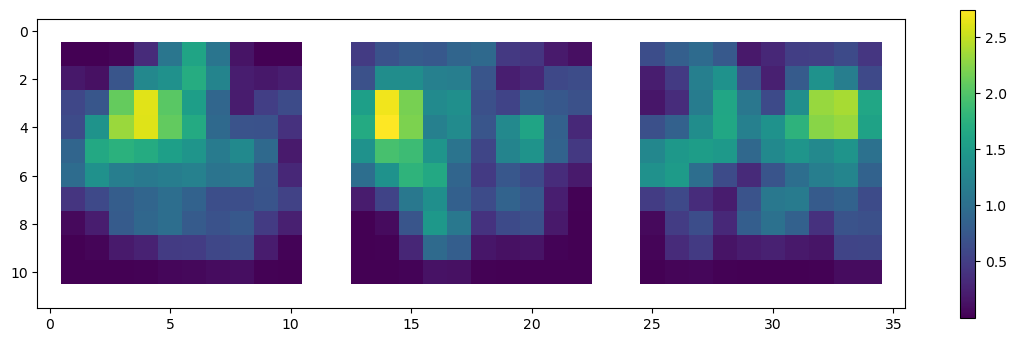

In [15]:
def normalize_time(df):
    g = df[["event_id", "time"]].groupby("event_id")
    times = g.quantile(0.5).rename(dict(time="t_mid")).with_columns(pl.col("t_mid").cast(pl.Int64))
    return df.join(times, on="event_id").with_columns((pl.col("time") - pl.col("t_mid")).alias("time_norm"))

NBINS_T = 10
NBINS_S = 10

def preprocess_batch(batch_df):
    # Time bins:
    tbins = np.linspace(-5000, 10000, NBINS_T + 1)
    tbin_width = tbins[1] - tbins[0]
    tbin_centers = (tbins[:-1] + tbins[1:]) / 2

    # Spacial bins:
    sbins = np.linspace(-600, 600, NBINS_S + 1)
    sbin_width = sbins[1] - sbins[0]
    sbin_centers = (sbins[:-1] + sbins[1:]) / 2

    # Normalize time and calculate a gaussian-like contribution of each pulse to each bin.
    # We group all the data by `event_id` and then aggregate each group with the code below.
    return normalize_time(batch_df).groupby("event_id").agg([
        ((
            np.exp(-(                                           #
                ((pl.col("time_norm") - tmid) / tbin_width)**2  #  <== Calculate the gaussian-smoothed
                + ((pl.col(ax) - smid) / sbin_width)**2         #  <== contribution of each pulse to each bin
            ))
        # Then weight by charge, calculate per bin sum and rename (we'll get a separate column per each bin):
        ) * pl.col("charge")).sum().alias(f"t_{int(tmid)}_{ax}_{int(smid)}".replace('-', "m"))
        for ax in ["x", "y", "z"]                          #  <== Iterate over axes
        for tmid in tbin_centers for smid in sbin_centers  #  <== Iterate over bins
    ])

# Here's a function to check what a preprocessed event looks like.
# Note that we are plotting log(1 + amplitude).
def plot_example(i_batch=0, i_event=4):
    b_pulses, _ = load_batch_c("train", TRAIN_BIDS[i_batch])
    e_id = b_pulses["event_id"].unique().sort()[i_event]
    prep_batch = preprocess_batch(b_pulses.filter(pl.col("event_id") == e_id))
    print("Preprocessed batch shape:", prep_batch.shape)
    img = prep_batch.drop("event_id").to_numpy().reshape(3, NBINS_T, NBINS_S)  # 3 images (TX, TY, TZ) of NBINS_T by NBINS_S

    plt.figure(figsize=(14, 4))
    plt.imshow(np.concatenate([np.pad(np.log1p(x), 1, constant_values=np.nan) for x in img], axis=-1))
    plt.colorbar();

plot_example()

In the example above we ran preprocessing over just a single event. Running on an entire batch may take a considerable amount of time. In order to avoid repeatedly preprocessing our data, we'll make use of on-disk cache with `joblib.Memory`. This approach does not work very healthily when caching a function defined in an interactive Jupyter session (it may result in repeated calculations). Therefore, we'll use the `%%file` magic again to create and import such a function:

In [16]:
%%file preprocessing_cache.py

import numpy as np
import polars as pl
from joblib import Memory
memory = Memory("cache/")

@memory.cache(ignore=["load_batch", "preprocess_batch"])
def load_and_preprocess_batch(
    folder, batch_id, load_batch, preprocess_batch, num_subsample=None
):
    """
    Load and preprocess a batch, possibly taking only a subsample of a batch.
    
    Parameters
    ----------
    folder : str
        Which part of the data to process. Should be either "train" or "test".
    batch_id : int
        Index of the batch (as in the `batch_id` column).
    load_batch : Callable
        Function loading a batch (to pass the interactively defined `load_batch` function).
    preprocess_batch : Callable
        Function preprocessing a batch (to pass the interactively defined `preprocess_batch`
        function).
    num_subsample : int | None
        If provided, only preprocess a random subsample of this size from the batch.

    Returns
    -------
    polars.DataFrame
        Preprocessed pulses.
    polars.DataFrame
        Corresponding meta info.
    """
    batch_pulses, batch_meta = load_batch(folder, batch_id)
    if num_subsample is not None:
        ids = batch_pulses["event_id"].unique()
        ids = np.random.choice(ids, num_subsample, replace=False)
        batch_pulses = batch_pulses.filter(pl.col("event_id").is_in(ids.tolist()))
        batch_meta = batch_meta.filter(pl.col("event_id").is_in(ids.tolist()))
    batch_pulses = preprocess_batch(batch_pulses).sort(by="event_id")
    batch_meta = batch_meta.sort(by="event_id")

    assert batch_pulses["event_id"].series_equal(batch_meta["event_id"])
    return batch_pulses, batch_meta

Writing preprocessing_cache.py


Here's a simple wrapper around the above defined function:

In [17]:
import preprocessing_cache

def load_and_preprocess_batch(folder, i_batch, num_subsample=None):
    bids = dict(train=TRAIN_BIDS, test=TEST_BIDS)[folder]
    return preprocessing_cache.load_and_preprocess_batch(
        folder, bids[i_batch], load_batch, preprocess_batch, num_subsample
    )

Since we're done with examining single events, we can delete the in-memory cached function to free some RAM:

In [18]:
# Free the memory taken by the cached version of the loader function as we don't need it any more.

del load_batch_c
gc.collect()

8865

## Defining the dataset, model and running a training loop

First, we define our dataset as a subclass of `torch.utils.data.IterableDataset`:

In [19]:
class Dataset(torch.utils.data.IterableDataset):
    def __init__(self, folder, file_ids, batch_size, drop_each_last=True, num_subsample=None, with_evt_id=False):
        """
        Parameters
        ----------
        folder : str
            Which part of the data to process. Should be either "train" or "test".
        file_ids : Sequence[int]
            A collection of batch-file indices (positional) to use.
        batch_size : int
            Size of the output batches (not to be confused with the batches in which the pulses
            are provided by the competition).
        drop_each_last : bool
            Whether to avoid batches of size smaller than `batch_size`
        num_subsample : int | None
            Take this many elements from each file (`None` = take all).
        with_evt_id : bool
            Output event ids (useful for making and submitting the prediction).
        """
        super().__init__()
        self.folder = folder
        self.file_ids = file_ids
        self.batch_size = batch_size
        self.drop_each_last = drop_each_last
        self.num_subsample = num_subsample
        self.with_evt_id = with_evt_id

    def __iter__(self):
        for i in np.random.choice(len(self.file_ids), len(self.file_ids), replace=False):
            gc.collect()
            batch_x, batch_y = load_and_preprocess_batch(
                self.folder, self.file_ids[i], num_subsample=self.num_subsample
            )
            if "azimuth" in batch_y.columns:
                batch_y = batch_y[["azimuth", "zenith"]]
            else:
                batch_y = None

            evt_ids = batch_x["event_id"]
            batch_x = batch_x.drop("event_id")

            if self.num_subsample is not None:
                assert len(batch_x) == self.num_subsample

            for i_evt in range(0, len(batch_x), self.batch_size):
                minibatch_x = batch_x[i_evt: i_evt + self.batch_size]
                if self.drop_each_last and len(minibatch_x) < self.batch_size:
                    continue

                minibatch_x = torch.from_numpy(
                    minibatch_x.to_numpy().astype(np.float32).reshape(-1, 3, NBINS_T, NBINS_S)
                )
                minibatch_y = None if batch_y is None else (
                    torch.from_numpy(
                        batch_y[i_evt: i_evt + self.batch_size].to_numpy().astype(np.float32)
                    )
                )
                if self.with_evt_id:
                    yield minibatch_x, minibatch_y, evt_ids[i_evt: i_evt + self.batch_size]
                else:
                    yield minibatch_x, minibatch_y

Now the model.

**The architecture** is quite simple: process each of the 3 projections by a downsampling convolutional network, then proecss the result with a fully-connected network. The output will be a vector with 3 components from which we'll determine the angles later.

**The loss** will be calculated in the output vector representation. I.e., we'll take the target angles, convert them to a directional unit vector and calculate the MSE between this vector and our prediction.

**For monitoring**, we'll overwite a `on_epoch_end` lightning method, in which we'll create/update a plot of loss values.

In [20]:
assert NBINS_T == 10 and NBINS_S == 10, "Our model expects 10x10 representation"

class ConvPredictor(torch.nn.Module):
    def __init__(self, activation=torch.nn.ELU()):
        super().__init__()
        (self.model_tx, self.model_ty, self.model_tz) = [
            torch.nn.Sequential(
                torch.nn.Conv2d(1, 32, 3), activation, # 1x10 -> 32x8
                torch.nn.Conv2d(32, 64, 3), activation, # -> 64x6
                torch.nn.Conv2d(64, 128, 3), activation, # -> 128x4
                torch.nn.Conv2d(128, 256, 3), activation, # -> 256x2
            ) for _ in range(3)
        ]
        self.head = torch.nn.Sequential(
            torch.nn.Linear(3 * 256 * 2 * 2, 32), activation,
            torch.nn.Linear(32, 3)
        )

    def forward(self, x):
        # x shape is (BATCH, 3, 10, 10)
        x = torch.log(1.0 + x)
        tx, ty, tz = x[:, 0: 1], x[:, 1: 2], x[:, 2: 3]
        tx = self.model_tx(tx).view(x.shape[0], 256 * 4)
        ty = self.model_tx(ty).view(x.shape[0], 256 * 4)
        tz = self.model_tx(tz).view(x.shape[0], 256 * 4)
        pred = self.head(torch.cat([tx, ty, tz], axis=1))
        return pred

class LitModel(ptl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def calculate_loss(self, batch):
        (X,), (Y,) = batch
        (azimuth, zenith) = Y.T
        vx = torch.cos(azimuth) * torch.sin(zenith)
        vy = torch.sin(azimuth) * torch.sin(zenith)
        vz = torch.cos(zenith)
        v = torch.stack([vx, vy, vz], axis=1)

        pred_v = self.model(X)
        return torch.nn.functional.mse_loss(pred_v, v)

    def training_step(self, batch, batch_idx):
        loss = self.calculate_loss(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calculate_loss(batch)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-4)
        return opt

    def on_validation_end(self):
        super().on_validation_end()

        self.logger.experiment.flush()
        if not hasattr(self, "tb_reader"):
            self.tb_reader = event_accumulator.EventAccumulator(self.logger.log_dir)
            self.hdisplay = display("", display_id=True)
        ea = self.tb_reader
        ea.Reload()

        try:
            train_values = [(x.step, x.value) for x in ea.Scalars("train_loss")]
            val_values = [(x.step, x.value) for x in ea.Scalars("val_loss")]

            if hasattr(self, "last_fig"):
                plt.close(self.last_fig)

            self.last_fig = plt.figure()
            plt.plot(*zip(*train_values), label="Train")
            plt.plot(*zip(*val_values), label="Validation");
            plt.xlabel("Step")
            plt.ylabel("Loss")
            plt.legend()
            self.hdisplay.update(self.last_fig)
        except KeyError:
            pass


model = ConvPredictor()
lit_model = LitModel(model)

OK, it's time to train our model. For this example, we'll use a small subset of data, and only run training for a few epochs.

Train file ids: [629 499 135 480  90 456 304 235  72 532]
Validation file ids: [165]


Sanity Checking: 0it [00:00, ?it/s]

________________________________________________________________________________
[Memory] Calling preprocessing_cache.load_and_preprocess_batch...
load_and_preprocess_batch('train', 166, <function load_batch at 0x7f14c4ec3050>, <function preprocess_batch at 0x7f14b71e7d40>, 5000)
_______________________________________load_and_preprocess_batch - 13.2s, 0.2min


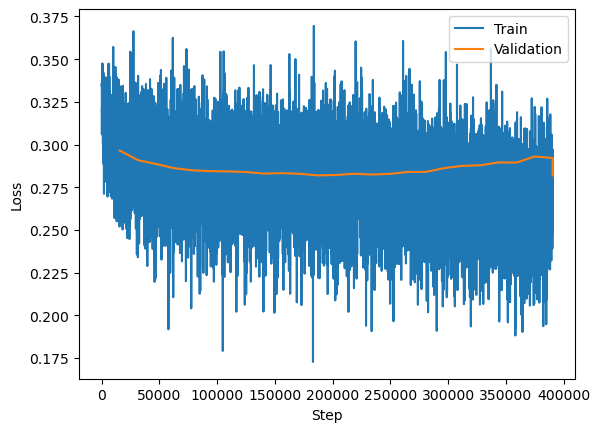

Training: 0it [00:00, ?it/s]

________________________________________________________________________________
[Memory] Calling preprocessing_cache.load_and_preprocess_batch...
load_and_preprocess_batch('train', 136, <function load_batch at 0x7f14c4ec3050>, <function preprocess_batch at 0x7f14b71e7d40>, 50000)
______________________________________load_and_preprocess_batch - 112.1s, 1.9min
________________________________________________________________________________
[Memory] Calling preprocessing_cache.load_and_preprocess_batch...
load_and_preprocess_batch('train', 500, <function load_batch at 0x7f14c4ec3050>, <function preprocess_batch at 0x7f14b71e7d40>, 50000)
______________________________________load_and_preprocess_batch - 125.5s, 2.1min
________________________________________________________________________________
[Memory] Calling preprocessing_cache.load_and_preprocess_batch...
load_and_preprocess_batch('train', 533, <function load_batch at 0x7f14c4ec3050>, <function preprocess_batch at 0x7f14b71e7d40>,

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

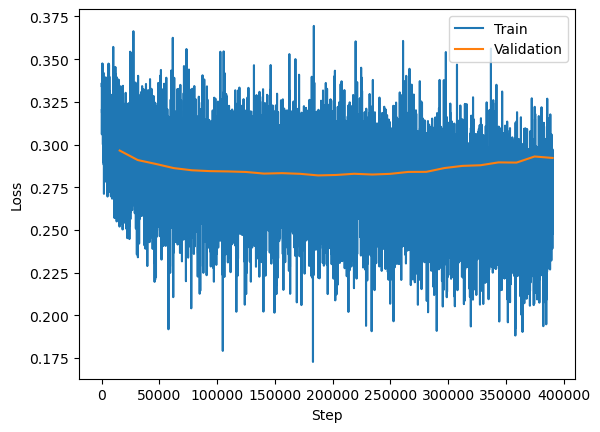

In [21]:
gc.collect()

np.random.seed(42)
use_n_files = 10
chosen_file_ids = np.random.choice(len(TRAIN_BIDS), use_n_files + 1, replace=False)
train_file_ids = chosen_file_ids[:-1]
val_file_ids = chosen_file_ids[-1:]
print("Train file ids:", train_file_ids)
print("Validation file ids:", val_file_ids)

train_dataset = Dataset(
    folder="train",
    file_ids=train_file_ids,
    batch_size=32,
    drop_each_last=True,
    num_subsample=50000,
)
val_dataset = Dataset(
    folder="train",
    file_ids=val_file_ids,
    batch_size=500,
    num_subsample=5000,
)
train_dataloader = torch.utils.data.DataLoader(train_dataset)
val_dataloader = torch.utils.data.DataLoader(val_dataset)

trainer = ptl.Trainer(
    max_epochs=25,
    callbacks=ptl.callbacks.ModelCheckpoint(monitor="val_loss"),
    accelerator='gpu', devices=1,
)
trainer.fit(model=lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [22]:
print(trainer.checkpoint_callback.best_model_score.detach().cpu().numpy())
print(trainer.checkpoint_callback.best_model_path)

0.28190333
/kaggle/working/lightning_logs/version_0/checkpoints/epoch=11-step=187440.ckpt


Let's restore the checkpoint with best score:

In [23]:
checkpoint = torch.load(trainer.checkpoint_callback.best_model_path)
lit_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.28190332651138306    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.28190332651138306}]

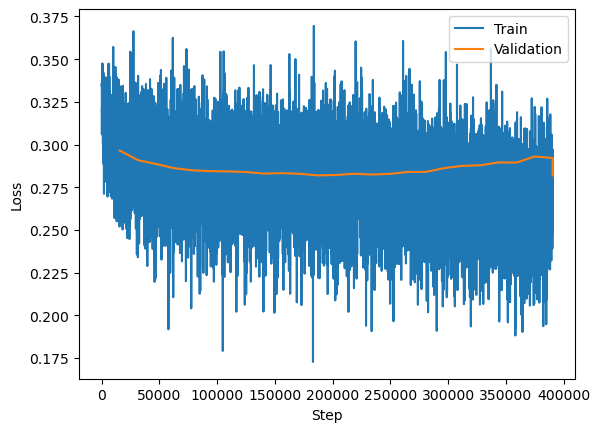

In [24]:
trainer.validate(lit_model, val_dataloader)

## Predicting on test and saving submission file

In [25]:
del trainer, train_dataset, val_dataset, train_dataloader, val_dataloader
gc.collect()

4210

In [26]:
def angles2vec(azimuth, zenith):
    x = torch.cos(azimuth) * torch.sin(zenith)
    y = torch.sin(azimuth) * torch.sin(zenith)
    z = torch.cos(zenith)
    return torch.stack([x, y, z], axis=1)

def vec2angles(vec):
    norm = ((vec**2).sum(axis=1)**0.5)[:, None]
    vec = vec / norm
    zenith = torch.acos(vec[:, 2])
    sin_zenith = torch.sin(zenith)
    cos_azimuth = vec[:, 0] / sin_zenith
    sin_azimuth = vec[:, 1] / sin_zenith
    azimuth = torch.atan2(sin_azimuth, cos_azimuth)
    return azimuth, zenith

In [27]:
test_ds = Dataset("test", list(range(len(TEST_BIDS))), batch_size=1000, drop_each_last=False, with_evt_id=True)

def torch2numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    return x
with torch.no_grad():
    predictions_df = pd.concat([
        pd.DataFrame({
            name: torch2numpy(value) for name, value in zip(
                ["event_id", "azimuth", "zenith"],
                (eids.to_numpy(),) + vec2angles(model(X))
            )
        }) for X, _, eids in test_ds
    ]).sort_values(by="event_id")

predictions_df.to_csv("submission.csv", index=False)

________________________________________________________________________________
[Memory] Calling preprocessing_cache.load_and_preprocess_batch...
load_and_preprocess_batch('test', 661, <function load_batch at 0x7f14c4ec3050>, <function preprocess_batch at 0x7f14b71e7d40>, None)
________________________________________load_and_preprocess_batch - 0.1s, 0.0min


In [28]:
!head submission.csv

event_id,azimuth,zenith
2092,0.6090121,0.35576466
7344,0.8820102,0.44702137
9482,1.3383188,1.886106
